In [9]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [10]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [21]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)
print(np.rad2deg(np.arccos(state[0])))
print(np.rad2deg(np.arcsin(state[1])))

[-0.72462816 -0.68914007  0.09773225]
[1.7023865]
[-0.73024665 -0.6831836  -0.16376482] -5.674400063939184 False {}
136.9070752505803
-43.09292474941971


In [29]:
from Discretization import Discretization

larry = Discretization("degree_only", "Pendulum",state_space_size=(18+1, 17), action_space_size=17)

print("Discrete action space: ")
print(larry.action_space)
print("Discrete state space: ")
print(larry.state_space)

Discrete action space: 
[-2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.  ]
Discrete state space: 
(array([-180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,  -20.,
          0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
        180.]), array([-8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.]))


Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


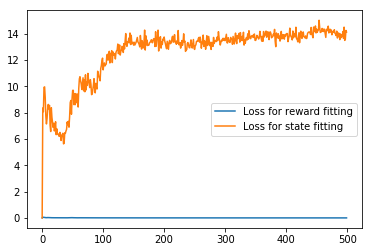

In [32]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Learning episodes / amount of samples for regression
epochs = 10000

rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()
# Only use degree of pendulum and degree velocity
old_state = np.array([np.rad2deg(np.arccos(old_state[0])), old_state[2]])

print("Regression...")
for i in range(epochs):
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    # Only use degree of pendulum and degree velocity
    next_state = np.array([np.rad2deg(np.arccos(next_state[0])), next_state[2]])

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    
    if i%20==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [17]:
"""
   Value Iteration
   
"""

def value_iteration(disc, theta, gamma):
    
    print("Value iteration...")

    value_function = np.ones(shape=disc.state_space_size)
    policy = np.ones(shape=disc.state_space_size)
    
    delta = theta
    
    while delta >= theta:
        
        delta = 0
        
        for s0 in disc.state_space[0]:
            for s1 in disc.state_space[1]:
                for s2 in disc.state_space[2]:
                    # Get (only positive) indexes for (possibly negative) discrete state(s)
                    index = disc.map_to_index([s0, s1, s2])
                    print(index)
                    
                    v = value_function[index[0], index[1], index[2]]
                    
                    # Iterate over all actions to get action maximizing expected reward
                    amax = 2
                    rmax = -100
                    for a in disc.action_space:
                        
                        for a in disc.action_space:
                            # Get sufficient state and reward from regressors
                            x = np.array([s0, s1, s2, a])
                            x = x.reshape(1,-1)
                            next_s = regressorState.predict(x).T.reshape(-1,)
                            r = regressorReward.predict(x)
                            
                            # Discretize sufficient state
                            next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                            # Calculate expected reward
                            # Deterministic case; we do not need probability distribution
                            expected_reward = r + gamma*value_function[next_index[0], next_index[1], next_index[2]]
                            
                            if rmax < expected_reward:
                                amax = a
                                rmax = expected_reward 
                    
                    # Define value function by maximum expected reward per state
                    value_function[index[0], index[1], index[2]] = rmax
                    # Define policy by action achieving maximum expected reward per state
                    policy[index[0], index[1], index[2]] = amax

        print("Delta: ", delta)
                    
                    
    print()
    print("...done")
    return value_function, policy

value_function, policy = value_iteration(disc=larry, theta=1.0, gamma=0.1)
                    

Value iteration...
[0, 0, 0]
[0, 0, 1]
[0, 0, 2]
[0, 0, 3]
[0, 0, 4]
[0, 0, 5]
[0, 0, 6]
[0, 0, 7]
[0, 0, 8]
[0, 0, 9]
[0, 0, 10]
[0, 0, 11]
[0, 0, 12]
[0, 0, 13]
[0, 0, 14]
[0, 0, 15]
[0, 0, 16]
[0, 1, 0]
[0, 1, 1]
[0, 1, 2]
[0, 1, 3]
[0, 1, 4]
[0, 1, 5]
[0, 1, 6]
[0, 1, 7]
[0, 1, 8]
[0, 1, 9]
[0, 1, 10]
[0, 1, 11]
[0, 1, 12]
[0, 1, 13]
[0, 1, 14]
[0, 1, 15]
[0, 1, 16]
[0, 2, 0]
[0, 2, 1]
[0, 2, 2]
[0, 2, 3]
[0, 2, 4]
[0, 2, 5]
[0, 2, 6]
[0, 2, 7]
[0, 2, 8]
[0, 2, 9]
[0, 2, 10]
[0, 2, 11]
[0, 2, 12]
[0, 2, 13]
[0, 2, 14]
[0, 2, 15]
[0, 2, 16]
[0, 3, 0]
[0, 3, 1]
[0, 3, 2]
[0, 3, 3]
[0, 3, 4]
[0, 3, 5]
[0, 3, 6]
[0, 3, 7]
[0, 3, 8]
[0, 3, 9]
[0, 3, 10]
[0, 3, 11]
[0, 3, 12]
[0, 3, 13]
[0, 3, 14]
[0, 3, 15]
[0, 3, 16]
[0, 4, 0]
[0, 4, 1]
[0, 4, 2]
[0, 4, 3]
[0, 4, 4]
[0, 4, 5]
[0, 4, 6]
[0, 4, 7]
[0, 4, 8]
[0, 4, 9]
[0, 4, 10]
[0, 4, 11]
[0, 4, 12]
[0, 4, 13]
[0, 4, 14]
[0, 4, 15]
[0, 4, 16]
[0, 5, 0]
[0, 5, 1]
[0, 5, 2]
[0, 5, 3]
[0, 5, 4]
[0, 5, 5]
[0, 5, 6]
[0, 5, 7]
[0, 5, 8]
[0, 5,

[2, 2, 2]
[2, 2, 3]
[2, 2, 4]
[2, 2, 5]
[2, 2, 6]
[2, 2, 7]
[2, 2, 8]
[2, 2, 9]
[2, 2, 10]
[2, 2, 11]
[2, 2, 12]
[2, 2, 13]
[2, 2, 14]
[2, 2, 15]
[2, 2, 16]
[2, 3, 0]
[2, 3, 1]
[2, 3, 2]
[2, 3, 3]
[2, 3, 4]
[2, 3, 5]
[2, 3, 6]
[2, 3, 7]
[2, 3, 8]
[2, 3, 9]
[2, 3, 10]
[2, 3, 11]
[2, 3, 12]
[2, 3, 13]
[2, 3, 14]
[2, 3, 15]
[2, 3, 16]
[2, 4, 0]
[2, 4, 1]
[2, 4, 2]
[2, 4, 3]
[2, 4, 4]
[2, 4, 5]
[2, 4, 6]
[2, 4, 7]
[2, 4, 8]
[2, 4, 9]
[2, 4, 10]
[2, 4, 11]
[2, 4, 12]
[2, 4, 13]
[2, 4, 14]
[2, 4, 15]
[2, 4, 16]
[2, 5, 0]
[2, 5, 1]
[2, 5, 2]
[2, 5, 3]
[2, 5, 4]
[2, 5, 5]
[2, 5, 6]
[2, 5, 7]
[2, 5, 8]
[2, 5, 9]
[2, 5, 10]
[2, 5, 11]
[2, 5, 12]
[2, 5, 13]
[2, 5, 14]
[2, 5, 15]
[2, 5, 16]
[2, 6, 0]
[2, 6, 1]
[2, 6, 2]
[2, 6, 3]
[2, 6, 4]
[2, 6, 5]
[2, 6, 6]
[2, 6, 7]
[2, 6, 8]
[2, 6, 9]
[2, 6, 10]
[2, 6, 11]
[2, 6, 12]
[2, 6, 13]
[2, 6, 14]
[2, 6, 15]
[2, 6, 16]
[2, 7, 0]
[2, 7, 1]
[2, 7, 2]
[2, 7, 3]
[2, 7, 4]
[2, 7, 5]
[2, 7, 6]
[2, 7, 7]
[2, 7, 8]
[2, 7, 9]
[2, 7, 10]
[2, 7, 11]
[2, 7, 12]
[2

[4, 4, 12]
[4, 4, 13]
[4, 4, 14]
[4, 4, 15]
[4, 4, 16]
[4, 5, 0]
[4, 5, 1]
[4, 5, 2]
[4, 5, 3]
[4, 5, 4]
[4, 5, 5]
[4, 5, 6]
[4, 5, 7]
[4, 5, 8]
[4, 5, 9]
[4, 5, 10]
[4, 5, 11]
[4, 5, 12]
[4, 5, 13]
[4, 5, 14]
[4, 5, 15]
[4, 5, 16]
[4, 6, 0]
[4, 6, 1]
[4, 6, 2]
[4, 6, 3]
[4, 6, 4]
[4, 6, 5]
[4, 6, 6]
[4, 6, 7]
[4, 6, 8]
[4, 6, 9]
[4, 6, 10]
[4, 6, 11]
[4, 6, 12]
[4, 6, 13]
[4, 6, 14]
[4, 6, 15]
[4, 6, 16]
[4, 7, 0]
[4, 7, 1]
[4, 7, 2]
[4, 7, 3]
[4, 7, 4]
[4, 7, 5]
[4, 7, 6]
[4, 7, 7]
[4, 7, 8]
[4, 7, 9]
[4, 7, 10]
[4, 7, 11]
[4, 7, 12]
[4, 7, 13]
[4, 7, 14]
[4, 7, 15]
[4, 7, 16]
[4, 8, 0]
[4, 8, 1]
[4, 8, 2]
[4, 8, 3]
[4, 8, 4]
[4, 8, 5]
[4, 8, 6]
[4, 8, 7]
[4, 8, 8]
[4, 8, 9]
[4, 8, 10]
[4, 8, 11]
[4, 8, 12]
[4, 8, 13]
[4, 8, 14]
[4, 8, 15]
[4, 8, 16]
[4, 9, 0]
[4, 9, 1]
[4, 9, 2]
[4, 9, 3]
[4, 9, 4]
[4, 9, 5]
[4, 9, 6]
[4, 9, 7]
[4, 9, 8]
[4, 9, 9]
[4, 9, 10]
[4, 9, 11]
[4, 9, 12]
[4, 9, 13]
[4, 9, 14]
[4, 9, 15]
[4, 9, 16]
[4, 10, 0]
[4, 10, 1]
[4, 10, 2]
[4, 10, 3]
[4, 10, 4]
[4, 1

[6, 6, 16]
[6, 7, 0]
[6, 7, 1]
[6, 7, 2]
[6, 7, 3]
[6, 7, 4]
[6, 7, 5]
[6, 7, 6]
[6, 7, 7]
[6, 7, 8]
[6, 7, 9]
[6, 7, 10]
[6, 7, 11]
[6, 7, 12]
[6, 7, 13]
[6, 7, 14]
[6, 7, 15]
[6, 7, 16]
[6, 8, 0]
[6, 8, 1]
[6, 8, 2]
[6, 8, 3]
[6, 8, 4]
[6, 8, 5]
[6, 8, 6]
[6, 8, 7]
[6, 8, 8]
[6, 8, 9]
[6, 8, 10]
[6, 8, 11]
[6, 8, 12]
[6, 8, 13]
[6, 8, 14]
[6, 8, 15]
[6, 8, 16]
[6, 9, 0]
[6, 9, 1]
[6, 9, 2]
[6, 9, 3]
[6, 9, 4]
[6, 9, 5]
[6, 9, 6]
[6, 9, 7]
[6, 9, 8]
[6, 9, 9]
[6, 9, 10]
[6, 9, 11]
[6, 9, 12]
[6, 9, 13]
[6, 9, 14]
[6, 9, 15]
[6, 9, 16]
[6, 10, 0]
[6, 10, 1]
[6, 10, 2]
[6, 10, 3]
[6, 10, 4]
[6, 10, 5]
[6, 10, 6]
[6, 10, 7]
[6, 10, 8]
[6, 10, 9]
[6, 10, 10]
[6, 10, 11]
[6, 10, 12]
[6, 10, 13]
[6, 10, 14]
[6, 10, 15]
[6, 10, 16]
[6, 11, 0]
[6, 11, 1]
[6, 11, 2]
[6, 11, 3]
[6, 11, 4]
[6, 11, 5]
[6, 11, 6]
[6, 11, 7]
[6, 11, 8]
[6, 11, 9]
[6, 11, 10]
[6, 11, 11]
[6, 11, 12]
[6, 11, 13]
[6, 11, 14]
[6, 11, 15]
[6, 11, 16]
[6, 12, 0]
[6, 12, 1]
[6, 12, 2]
[6, 12, 3]
[6, 12, 4]
[6, 12, 5]
[6, 

[8, 9, 3]
[8, 9, 4]
[8, 9, 5]
[8, 9, 6]
[8, 9, 7]
[8, 9, 8]
[8, 9, 9]
[8, 9, 10]
[8, 9, 11]
[8, 9, 12]
[8, 9, 13]
[8, 9, 14]
[8, 9, 15]
[8, 9, 16]
[8, 10, 0]
[8, 10, 1]
[8, 10, 2]
[8, 10, 3]
[8, 10, 4]
[8, 10, 5]
[8, 10, 6]
[8, 10, 7]
[8, 10, 8]
[8, 10, 9]
[8, 10, 10]
[8, 10, 11]
[8, 10, 12]
[8, 10, 13]
[8, 10, 14]
[8, 10, 15]
[8, 10, 16]
[8, 11, 0]
[8, 11, 1]
[8, 11, 2]
[8, 11, 3]
[8, 11, 4]
[8, 11, 5]
[8, 11, 6]
[8, 11, 7]
[8, 11, 8]
[8, 11, 9]
[8, 11, 10]
[8, 11, 11]
[8, 11, 12]
[8, 11, 13]
[8, 11, 14]
[8, 11, 15]
[8, 11, 16]
[8, 12, 0]
[8, 12, 1]
[8, 12, 2]
[8, 12, 3]
[8, 12, 4]
[8, 12, 5]
[8, 12, 6]
[8, 12, 7]
[8, 12, 8]
[8, 12, 9]
[8, 12, 10]
[8, 12, 11]
[8, 12, 12]
[8, 12, 13]
[8, 12, 14]
[8, 12, 15]
[8, 12, 16]
[8, 13, 0]
[8, 13, 1]
[8, 13, 2]
[8, 13, 3]
[8, 13, 4]
[8, 13, 5]
[8, 13, 6]
[8, 13, 7]
[8, 13, 8]
[8, 13, 9]
[8, 13, 10]
[8, 13, 11]
[8, 13, 12]
[8, 13, 13]
[8, 13, 14]
[8, 13, 15]
[8, 13, 16]
[8, 14, 0]
[8, 14, 1]
[8, 14, 2]
[8, 14, 3]
[8, 14, 4]
[8, 14, 5]
[8, 14, 6]


[10, 10, 8]
[10, 10, 9]
[10, 10, 10]
[10, 10, 11]
[10, 10, 12]
[10, 10, 13]
[10, 10, 14]
[10, 10, 15]
[10, 10, 16]
[10, 11, 0]
[10, 11, 1]
[10, 11, 2]
[10, 11, 3]
[10, 11, 4]
[10, 11, 5]
[10, 11, 6]
[10, 11, 7]
[10, 11, 8]
[10, 11, 9]
[10, 11, 10]
[10, 11, 11]
[10, 11, 12]
[10, 11, 13]
[10, 11, 14]
[10, 11, 15]
[10, 11, 16]
[10, 12, 0]
[10, 12, 1]
[10, 12, 2]
[10, 12, 3]
[10, 12, 4]
[10, 12, 5]
[10, 12, 6]
[10, 12, 7]
[10, 12, 8]
[10, 12, 9]
[10, 12, 10]
[10, 12, 11]
[10, 12, 12]
[10, 12, 13]
[10, 12, 14]
[10, 12, 15]
[10, 12, 16]
[10, 13, 0]
[10, 13, 1]
[10, 13, 2]
[10, 13, 3]
[10, 13, 4]
[10, 13, 5]
[10, 13, 6]
[10, 13, 7]
[10, 13, 8]
[10, 13, 9]
[10, 13, 10]
[10, 13, 11]
[10, 13, 12]
[10, 13, 13]
[10, 13, 14]
[10, 13, 15]
[10, 13, 16]
[10, 14, 0]
[10, 14, 1]
[10, 14, 2]
[10, 14, 3]
[10, 14, 4]
[10, 14, 5]
[10, 14, 6]
[10, 14, 7]
[10, 14, 8]
[10, 14, 9]
[10, 14, 10]
[10, 14, 11]
[10, 14, 12]
[10, 14, 13]
[10, 14, 14]
[10, 14, 15]
[10, 14, 16]
[10, 15, 0]
[10, 15, 1]
[10, 15, 2]
[10, 

[12, 9, 0]
[12, 9, 1]
[12, 9, 2]
[12, 9, 3]
[12, 9, 4]
[12, 9, 5]
[12, 9, 6]
[12, 9, 7]
[12, 9, 8]
[12, 9, 9]
[12, 9, 10]
[12, 9, 11]
[12, 9, 12]
[12, 9, 13]
[12, 9, 14]
[12, 9, 15]
[12, 9, 16]
[12, 10, 0]
[12, 10, 1]
[12, 10, 2]
[12, 10, 3]
[12, 10, 4]
[12, 10, 5]
[12, 10, 6]
[12, 10, 7]
[12, 10, 8]
[12, 10, 9]
[12, 10, 10]
[12, 10, 11]
[12, 10, 12]
[12, 10, 13]
[12, 10, 14]
[12, 10, 15]
[12, 10, 16]
[12, 11, 0]
[12, 11, 1]
[12, 11, 2]
[12, 11, 3]
[12, 11, 4]
[12, 11, 5]
[12, 11, 6]
[12, 11, 7]
[12, 11, 8]
[12, 11, 9]
[12, 11, 10]
[12, 11, 11]
[12, 11, 12]
[12, 11, 13]
[12, 11, 14]
[12, 11, 15]
[12, 11, 16]
[12, 12, 0]
[12, 12, 1]
[12, 12, 2]
[12, 12, 3]
[12, 12, 4]
[12, 12, 5]
[12, 12, 6]
[12, 12, 7]
[12, 12, 8]
[12, 12, 9]
[12, 12, 10]
[12, 12, 11]
[12, 12, 12]
[12, 12, 13]
[12, 12, 14]
[12, 12, 15]
[12, 12, 16]
[12, 13, 0]
[12, 13, 1]
[12, 13, 2]
[12, 13, 3]
[12, 13, 4]
[12, 13, 5]
[12, 13, 6]
[12, 13, 7]
[12, 13, 8]
[12, 13, 9]
[12, 13, 10]
[12, 13, 11]
[12, 13, 12]
[12, 13, 13]
[

[14, 7, 6]
[14, 7, 7]
[14, 7, 8]
[14, 7, 9]
[14, 7, 10]
[14, 7, 11]
[14, 7, 12]
[14, 7, 13]
[14, 7, 14]
[14, 7, 15]
[14, 7, 16]
[14, 8, 0]
[14, 8, 1]
[14, 8, 2]
[14, 8, 3]
[14, 8, 4]
[14, 8, 5]
[14, 8, 6]
[14, 8, 7]
[14, 8, 8]
[14, 8, 9]
[14, 8, 10]
[14, 8, 11]
[14, 8, 12]
[14, 8, 13]
[14, 8, 14]
[14, 8, 15]
[14, 8, 16]
[14, 9, 0]
[14, 9, 1]
[14, 9, 2]
[14, 9, 3]
[14, 9, 4]
[14, 9, 5]
[14, 9, 6]
[14, 9, 7]
[14, 9, 8]
[14, 9, 9]
[14, 9, 10]
[14, 9, 11]
[14, 9, 12]
[14, 9, 13]
[14, 9, 14]
[14, 9, 15]
[14, 9, 16]
[14, 10, 0]
[14, 10, 1]
[14, 10, 2]
[14, 10, 3]
[14, 10, 4]
[14, 10, 5]
[14, 10, 6]
[14, 10, 7]
[14, 10, 8]
[14, 10, 9]
[14, 10, 10]
[14, 10, 11]
[14, 10, 12]
[14, 10, 13]
[14, 10, 14]
[14, 10, 15]
[14, 10, 16]
[14, 11, 0]
[14, 11, 1]
[14, 11, 2]
[14, 11, 3]
[14, 11, 4]
[14, 11, 5]
[14, 11, 6]
[14, 11, 7]
[14, 11, 8]
[14, 11, 9]
[14, 11, 10]
[14, 11, 11]
[14, 11, 12]
[14, 11, 13]
[14, 11, 14]
[14, 11, 15]
[14, 11, 16]
[14, 12, 0]
[14, 12, 1]
[14, 12, 2]
[14, 12, 3]
[14, 12, 4]
[1

[16, 5, 13]
[16, 5, 14]
[16, 5, 15]
[16, 5, 16]
[16, 6, 0]
[16, 6, 1]
[16, 6, 2]
[16, 6, 3]
[16, 6, 4]
[16, 6, 5]
[16, 6, 6]
[16, 6, 7]
[16, 6, 8]
[16, 6, 9]
[16, 6, 10]
[16, 6, 11]
[16, 6, 12]
[16, 6, 13]
[16, 6, 14]
[16, 6, 15]
[16, 6, 16]
[16, 7, 0]
[16, 7, 1]
[16, 7, 2]
[16, 7, 3]
[16, 7, 4]
[16, 7, 5]
[16, 7, 6]
[16, 7, 7]
[16, 7, 8]
[16, 7, 9]
[16, 7, 10]
[16, 7, 11]
[16, 7, 12]
[16, 7, 13]
[16, 7, 14]
[16, 7, 15]
[16, 7, 16]
[16, 8, 0]
[16, 8, 1]
[16, 8, 2]
[16, 8, 3]
[16, 8, 4]
[16, 8, 5]
[16, 8, 6]
[16, 8, 7]
[16, 8, 8]
[16, 8, 9]
[16, 8, 10]
[16, 8, 11]
[16, 8, 12]
[16, 8, 13]
[16, 8, 14]
[16, 8, 15]
[16, 8, 16]
[16, 9, 0]
[16, 9, 1]
[16, 9, 2]
[16, 9, 3]
[16, 9, 4]
[16, 9, 5]
[16, 9, 6]
[16, 9, 7]
[16, 9, 8]
[16, 9, 9]
[16, 9, 10]
[16, 9, 11]
[16, 9, 12]
[16, 9, 13]
[16, 9, 14]
[16, 9, 15]
[16, 9, 16]
[16, 10, 0]
[16, 10, 1]
[16, 10, 2]
[16, 10, 3]
[16, 10, 4]
[16, 10, 5]
[16, 10, 6]
[16, 10, 7]
[16, 10, 8]
[16, 10, 9]
[16, 10, 10]
[16, 10, 11]
[16, 10, 12]
[16, 10, 13]
[16,

[18, 4, 4]
[18, 4, 5]
[18, 4, 6]
[18, 4, 7]
[18, 4, 8]
[18, 4, 9]
[18, 4, 10]
[18, 4, 11]
[18, 4, 12]
[18, 4, 13]
[18, 4, 14]
[18, 4, 15]
[18, 4, 16]
[18, 5, 0]
[18, 5, 1]
[18, 5, 2]
[18, 5, 3]
[18, 5, 4]
[18, 5, 5]
[18, 5, 6]
[18, 5, 7]
[18, 5, 8]
[18, 5, 9]
[18, 5, 10]
[18, 5, 11]
[18, 5, 12]
[18, 5, 13]
[18, 5, 14]
[18, 5, 15]
[18, 5, 16]
[18, 6, 0]
[18, 6, 1]
[18, 6, 2]
[18, 6, 3]
[18, 6, 4]
[18, 6, 5]
[18, 6, 6]
[18, 6, 7]
[18, 6, 8]
[18, 6, 9]
[18, 6, 10]
[18, 6, 11]
[18, 6, 12]
[18, 6, 13]
[18, 6, 14]
[18, 6, 15]
[18, 6, 16]
[18, 7, 0]
[18, 7, 1]
[18, 7, 2]
[18, 7, 3]
[18, 7, 4]
[18, 7, 5]
[18, 7, 6]
[18, 7, 7]
[18, 7, 8]
[18, 7, 9]
[18, 7, 10]
[18, 7, 11]
[18, 7, 12]
[18, 7, 13]
[18, 7, 14]
[18, 7, 15]
[18, 7, 16]
[18, 8, 0]
[18, 8, 1]
[18, 8, 2]
[18, 8, 3]
[18, 8, 4]
[18, 8, 5]
[18, 8, 6]
[18, 8, 7]
[18, 8, 8]
[18, 8, 9]
[18, 8, 10]
[18, 8, 11]
[18, 8, 12]
[18, 8, 13]
[18, 8, 14]
[18, 8, 15]
[18, 8, 16]
[18, 9, 0]
[18, 9, 1]
[18, 9, 2]
[18, 9, 3]
[18, 9, 4]
[18, 9, 5]
[18, 9, 

[20, 2, 12]
[20, 2, 13]
[20, 2, 14]
[20, 2, 15]
[20, 2, 16]
[20, 3, 0]
[20, 3, 1]
[20, 3, 2]
[20, 3, 3]
[20, 3, 4]
[20, 3, 5]
[20, 3, 6]
[20, 3, 7]
[20, 3, 8]
[20, 3, 9]
[20, 3, 10]
[20, 3, 11]
[20, 3, 12]
[20, 3, 13]
[20, 3, 14]
[20, 3, 15]
[20, 3, 16]
[20, 4, 0]
[20, 4, 1]
[20, 4, 2]
[20, 4, 3]
[20, 4, 4]
[20, 4, 5]
[20, 4, 6]
[20, 4, 7]
[20, 4, 8]
[20, 4, 9]
[20, 4, 10]
[20, 4, 11]
[20, 4, 12]
[20, 4, 13]
[20, 4, 14]
[20, 4, 15]
[20, 4, 16]
[20, 5, 0]
[20, 5, 1]
[20, 5, 2]
[20, 5, 3]
[20, 5, 4]
[20, 5, 5]
[20, 5, 6]
[20, 5, 7]
[20, 5, 8]
[20, 5, 9]
[20, 5, 10]
[20, 5, 11]
[20, 5, 12]
[20, 5, 13]
[20, 5, 14]
[20, 5, 15]
[20, 5, 16]
[20, 6, 0]
[20, 6, 1]
[20, 6, 2]
[20, 6, 3]
[20, 6, 4]
[20, 6, 5]
[20, 6, 6]
[20, 6, 7]
[20, 6, 8]
[20, 6, 9]
[20, 6, 10]
[20, 6, 11]
[20, 6, 12]
[20, 6, 13]
[20, 6, 14]
[20, 6, 15]
[20, 6, 16]
[20, 7, 0]
[20, 7, 1]
[20, 7, 2]
[20, 7, 3]
[20, 7, 4]
[20, 7, 5]
[20, 7, 6]
[20, 7, 7]
[20, 7, 8]
[20, 7, 9]
[20, 7, 10]
[20, 7, 11]
[20, 7, 12]
[20, 7, 13]
[20, 7

In [ ]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

def policy_iteration(disc, theta, gamma):        
    
    print("Policy iteration...")

    value_function = np.ones(shape=disc.state_space_size)
    policy = np.zeros(shape=disc.state_space_size)

    
    def policy_evaluation(theta, gamma):
        print()
        print("Evaluating policy")
        delta = theta
        while delta >= theta:
            delta = 0
            # Iteratate over discrete state space
            for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Get index for state 
                        # The method already iterates over a discretized state space
                        # But the states need to get mapped to a positive index do to possible 'negative' states
                        index = disc.map_to_index([s0, s1, s2])
                        
                        v = value_function[index[0], index[1], index[2]]
                        
                        """
                         V(s) = Sum...p(s',r|s,pi(s))[r+gamma*V(s')]
                         
                        """
                        a = policy[index[0], index[1], index[2]]
                        
                        # input for regression
                        x = np.array([s0, s1, s2, a]).reshape(1, -1)
                        
                        # Predict next state and reward with regressors
                        next_s = regressorState.predict(x).T.reshape(-1,)
                        r = regressorReward.predict(x)      
                        
                        next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                                          
                        value_function[index[0], index[1], index[2]] = r + gamma*value_function[next_index[0],
                                                                              next_index[1], next_index[2]]
                                          
                        delta = max(delta, v - value_function[index[0], index[1], index[2]])
            print("Delta: ", delta)
    
    
    def policy_improvement(gamma):
        print()
        print("Improving policy")
        policy_stable = True
        for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Indexing
                        index = disc.map_to_index([s0, s1, s2])
                        
                        old_action = policy[index[0], index[1], index[2]]
                        
                        """
                            pi(s) = argmax_a ... 
                            We do not have to care about the prob. distribution,
                            as we have a deterministic env.
                            
                        """
                        # Iterate over all actions and get the one with max. expected reward
                        amax = 2
                        rmax = -100
                        for a in disc.action_space:
                            x = np.array([s0, s1, s2, a])
                            x = x.reshape(1,-1)
                            next_s = regressorState.predict(x).T.reshape(-1,)
                            next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                            r = regressorReward.predict(x)
                            expected_reward = r + gamma*value_function[next_index[0], next_index[1], next_index[2]]
                            if rmax < expected_reward:
                                amax = a
                                rmax = expected_reward 
                        policy[index[0], index[1], index[2]] = amax # TODO
                        
                        if old_action != policy[index[0], index[1], index[2]]:
                            policy_stable = False
                            
        print("Policy stable: ", policy_stable)
        return policy_stable
        
    # Run until policy is stable
    stable_policy = False
    while not stable_policy:
        policy_evaluation(theta, gamma)
        stable_policy = policy_improvement(gamma)
    
    print()
    print("...done")
    return value_function, policy
    
# value_function, policy = policy_iteration(larry, theta=1, gamma=0.1)


In [ ]:
"""
    Some stuff to see the predictions, discretizations and learned functions in action

"""
rewards_per_episode = []

for e in range(5):
    
    # Discretize first state
    index = larry.map_to_index(env.reset())
    
    rewards_per_timestep = []
    
    for t in range(1000):
        # Render environment
        # env.render()

        # Do step according to policy and get observation and reward
        action = np.array([policy[index[0], index[1], index[2]]])
        print(action)
        #action = env.action_space.sample()
        observation, reward, done, info = env.step(action)

        rewards_per_timestep.append(reward)
        
        # Discretize observed state
        index = larry.map_to_index(observation)

        if done:
            print("Episode {} finished after {} timesteps".format(e+1, t+1))
            break
    
    rewards_per_episode.append(rewards_per_timestep)

# Average reward over episodes
rewards = np.average(rewards_per_episode, axis=0)
print(np.shape(rewards))
        
env.close()

# Plot rewards per timestep averaged over episodes
plt.figure()
plt.plot(rewards, label='Average reward per timestep')
plt.legend()
plt.show()